<a href="https://colab.research.google.com/github/Tavleen1203/Quantum_Reinforced_Trading/blob/main/qrl_trading_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.7/532.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.5/596.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 14.1 MB/s eta 

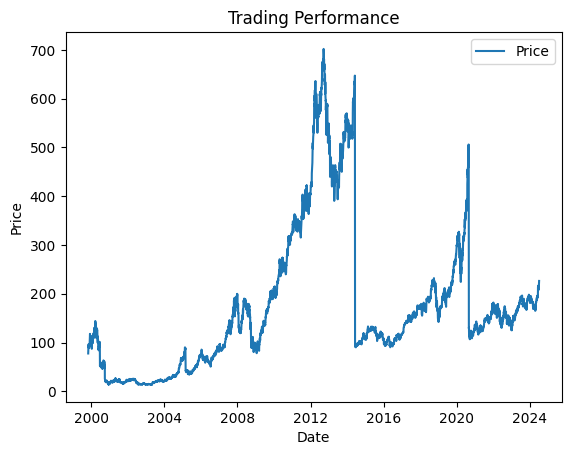


    Trading Performance Report
    ---------------------------
    Initial Cash: $10000
    Final Total Value: $27255.90
    Cumulative Return: 172.56%
    Sharpe Ratio: 0.03
    Maximum Drawdown: 75253.86
    


In [ ]:
!pip install alpha_vantage cirq pandas numpy matplotlib gym scikit-learn

from alpha_vantage.timeseries import TimeSeries
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import gym
from gym import spaces
import cirq
import matplotlib.pyplot as plt

# Fetching and Preparing Data
API_KEY = '0P7AK3J443222TZO'
symbol = 'AAPL'
ts = TimeSeries(key=API_KEY, output_format='pandas')
data, meta_data = ts.get_daily(symbol=symbol, outputsize='full')
data = data.sort_index()
data['returns'] = data['4. close'].pct_change().fillna(0)
scaler = StandardScaler()
data['returns_scaled'] = scaler.fit_transform(data[['returns']])
data['date'] = data.index
data = data.reset_index(drop=True)

# Trading Environment
class TradingEnv(gym.Env):
    def __init__(self, data):
        super(TradingEnv, self).__init__()
        self.data = data
        self.current_step = 0
        self.cash = 10000
        self.stock = 0
        self.total_value = self.cash
        self.action_space = spaces.Discrete(3)  # Buy, Hold, Sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32)
        self.history = []

    def reset(self):
        self.current_step = 0
        self.cash = 10000
        self.stock = 0
        self.total_value = self.cash
        self.history = [self.total_value]
        return self._next_observation()

    def _next_observation(self):
        return np.array([self.data.iloc[self.current_step]['returns_scaled']])

    def step(self, action):
        prev_total_value = self.total_value
        current_price = self.data.iloc[self.current_step]['4. close']

        if action == 0:  # Buy
            max_buy = int(self.cash // current_price)
            if max_buy > 0:
                self.stock += max_buy
                self.cash -= max_buy * current_price
        elif action == 2:  # Sell
            if self.stock > 0:
                self.cash += self.stock * current_price
                self.stock = 0

        self.current_step += 1
        self.total_value = self.cash + self.stock * current_price
        self.history.append(self.total_value)
        reward = self.total_value - prev_total_value

        if self.cash < 0 or self.stock < 0:
            reward -= 100  # Penalize unrealistic scenarios

        done = self.current_step >= len(self.data) - 1

        return self._next_observation(), reward, done, {}

    def render(self, mode='human'):
        if self.current_step in [0, len(self.data) // 2, len(self.data) - 1]:
            print(f'Step: {self.current_step}')
            print(f'Cash: {self.cash}')
            print(f'Stock: {self.stock}')
            print(f'Total Value: {self.total_value}')

# Quantum Trading Agent
class QuantumTradingAgent:
    def __init__(self):
        self.qubit = cirq.GridQubit(0, 0)
        self.circuit = cirq.Circuit()
        self.learning_rate = 0.1
        self.discount_factor = 0.99
        self.exploration_rate = 1.0
        self.exploration_decay = 0.995
        self.min_exploration_rate = 0.01
        self.q_table = {}

    def select_action(self, state, current_step, total_steps):
        state_tuple = tuple(state)
        if np.random.rand() < self.exploration_rate:
            action = np.random.randint(0, 3)
        else:
            action = self._get_best_action(state_tuple)

        self.circuit = cirq.Circuit()
        self.circuit.append(cirq.X(self.qubit)**state)
        self.circuit.append(cirq.H(self.qubit))
        self.circuit.append(cirq.measure(self.qubit, key='result'))

        simulator = cirq.Simulator()
        result = simulator.run(self.circuit, repetitions=1)

        measurement = result.measurements['result'][0][0]
        action = measurement % 3

        if current_step in [0, total_steps // 2, total_steps - 1]:
            print(f"Action selected: {action}")

        return action

    def update(self, state, action, reward, next_state):
        state_tuple = tuple(state)
        next_state_tuple = tuple(next_state)
        best_next_action = self._get_best_action(next_state_tuple)
        old_value = self.q_table.get((state_tuple, action), 0)
        next_max = self.q_table.get((next_state_tuple, best_next_action), 0)

        new_value = (1 - self.learning_rate) * old_value + self.learning_rate * (reward + self.discount_factor * next_max)
        self.q_table[(state_tuple, action)] = new_value

        if self.exploration_rate > self.min_exploration_rate:
            self.exploration_rate *= self.exploration_decay

    def _get_best_action(self, state):
        q_values = [self.q_table.get((state, a), 0) for a in range(3)]
        return np.argmax(q_values)

# Performance Metrics
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    return excess_returns.mean() / excess_returns.std()

def calculate_max_drawdown(history):
    drawdowns = np.maximum.accumulate(history) - history
    return np.max(drawdowns)

# Training the Agent
env = TradingEnv(data)
agent = QuantumTradingAgent()
episodes = 5
total_steps = len(data)

for episode in range(episodes):
    print(f"Episode: {episode + 1}")
    state = env.reset()
    done = False

    while not done:
        action = agent.select_action(state, env.current_step, total_steps)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state)
        state = next_state
        env.render()

cumulative_return = (env.total_value - 10000) / 10000
returns = pd.Series(env.history).pct_change().fillna(0)
sharpe_ratio = calculate_sharpe_ratio(returns)
max_drawdown = calculate_max_drawdown(env.history)

# Visualization
plt.plot(data['date'], data['4. close'], label='Price')
plt.title('Trading Performance')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Generate Report
def generate_report(env, cumulative_return, sharpe_ratio, max_drawdown):
    report = f'''
    Trading Performance Report
    ---------------------------
    Initial Cash: $10000
    Final Total Value: ${env.total_value:.2f}
    Cumulative Return: {cumulative_return * 100:.2f}%
    Sharpe Ratio: {sharpe_ratio:.2f}
    Maximum Drawdown: {max_drawdown:.2f}
    '''
    print(report)

generate_report(env, cumulative_return, sharpe_ratio, max_drawdown)


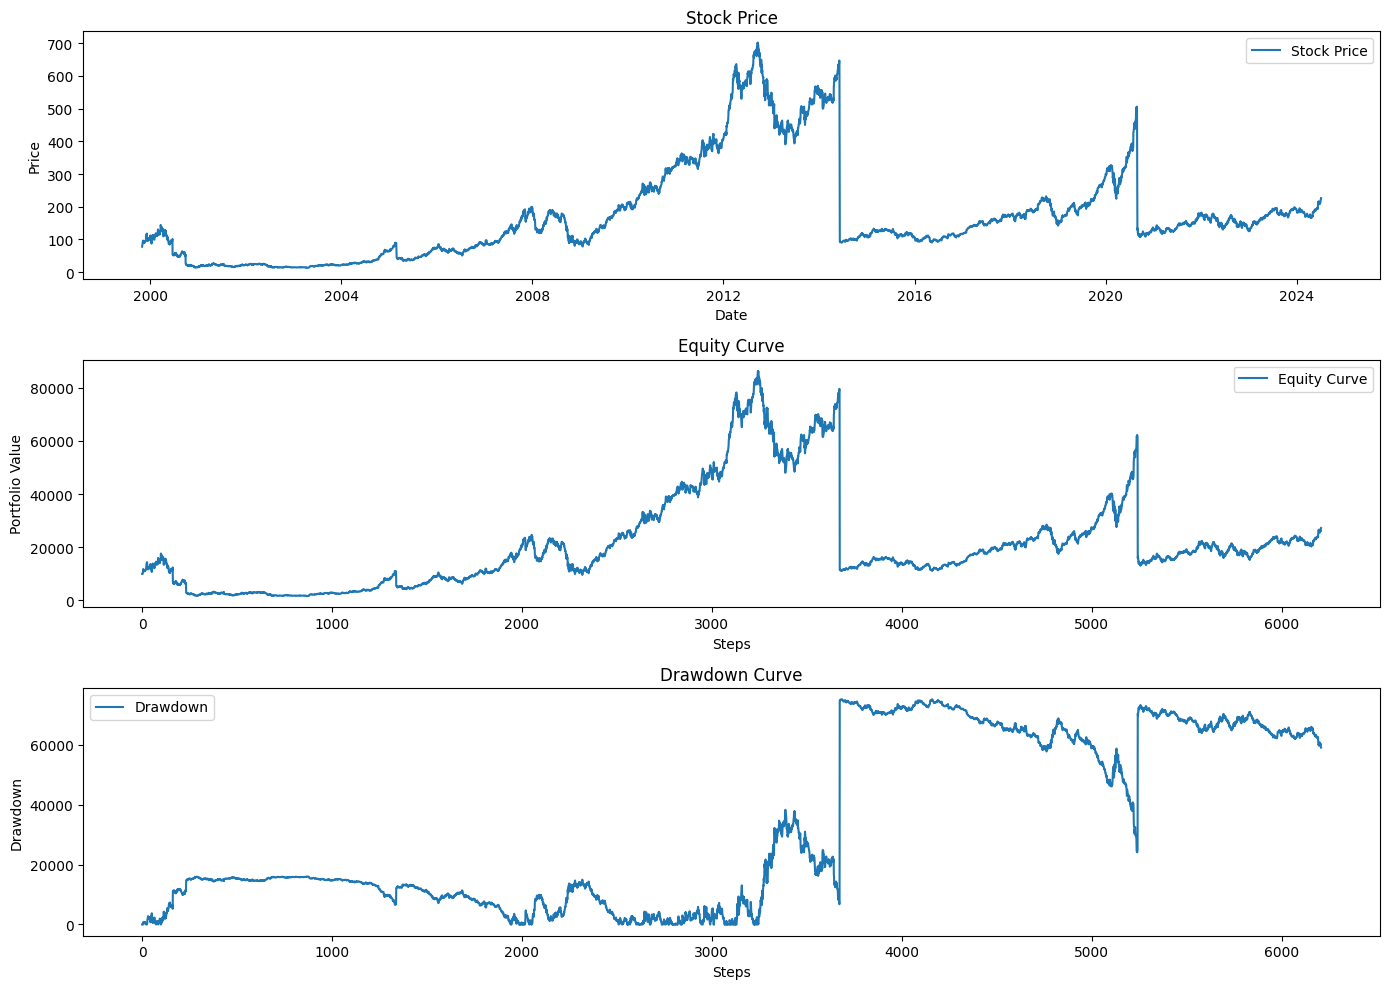

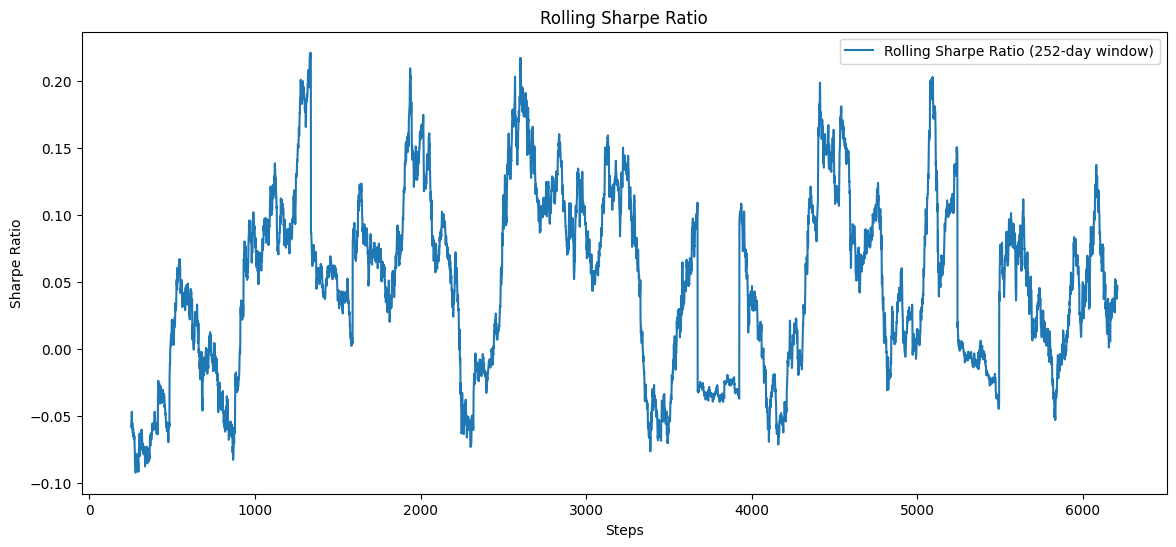

In [ ]:
import matplotlib.pyplot as plt

# Visualization of Equity Curve
plt.figure(figsize=(14, 10))

# Stock Price
plt.subplot(3, 1, 1)
plt.plot(data['date'], data['4. close'], label='Stock Price')
plt.title('Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Equity Curve
plt.subplot(3, 1, 2)
plt.plot(env.history, label='Equity Curve')
plt.title('Equity Curve')
plt.xlabel('Steps')
plt.ylabel('Portfolio Value')
plt.legend()

# Drawdown Curve
drawdown = np.maximum.accumulate(env.history) - env.history
plt.subplot(3, 1, 3)
plt.plot(drawdown, label='Drawdown')
plt.title('Drawdown Curve')
plt.xlabel('Steps')
plt.ylabel('Drawdown')
plt.legend()

plt.tight_layout()
plt.show()

# Rolling Sharpe Ratio
rolling_sharpe = pd.Series(env.history).pct_change().fillna(0).rolling(window=252).apply(lambda x: calculate_sharpe_ratio(x), raw=False)

plt.figure(figsize=(14, 6))
plt.plot(rolling_sharpe, label='Rolling Sharpe Ratio (252-day window)')
plt.title('Rolling Sharpe Ratio')
plt.xlabel('Steps')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.show()



    Trading Performance Report
    ---------------------------
    Initial Cash: $10000
    Final Total Value: $27255.90
    Cumulative Return: 172.56%
    Sharpe Ratio: 0.03
    Maximum Drawdown: 75253.86
    


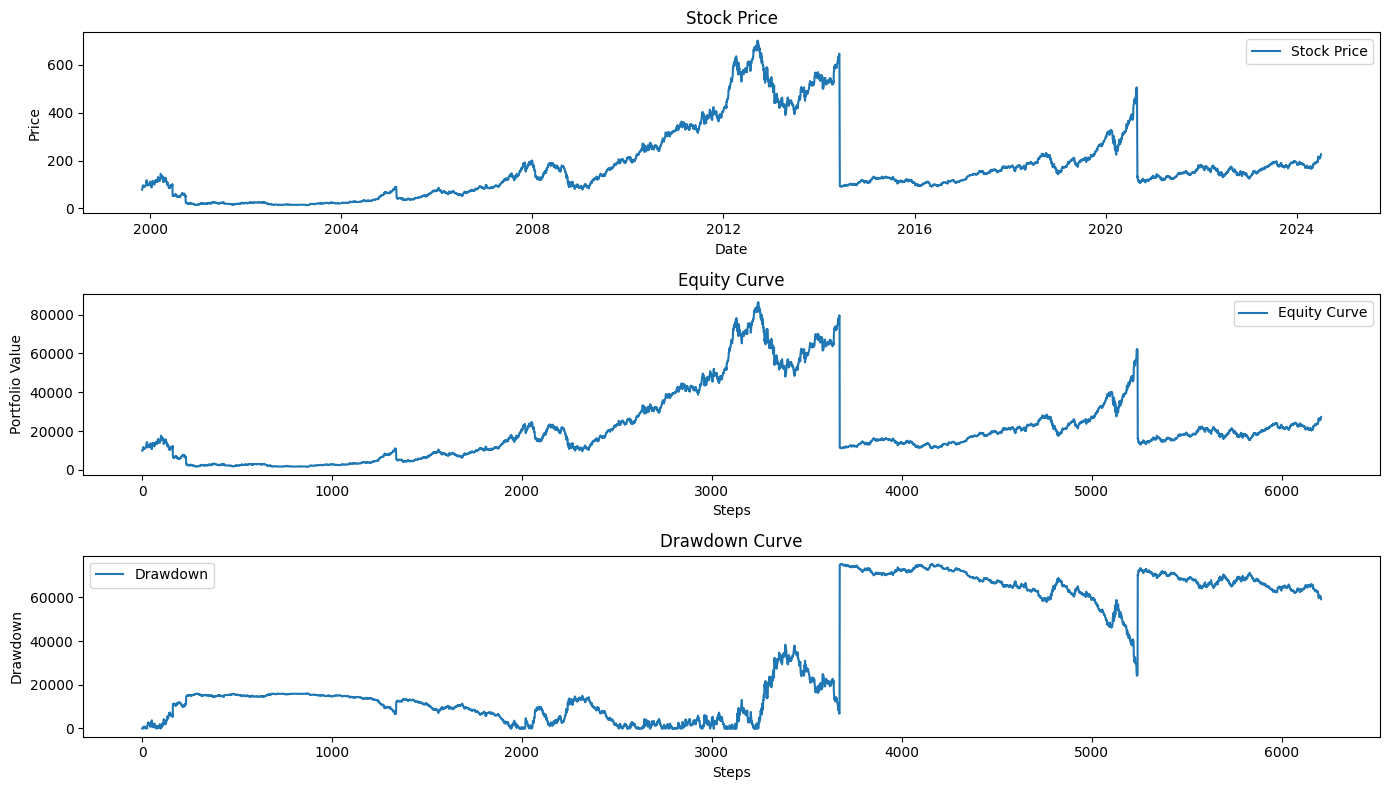

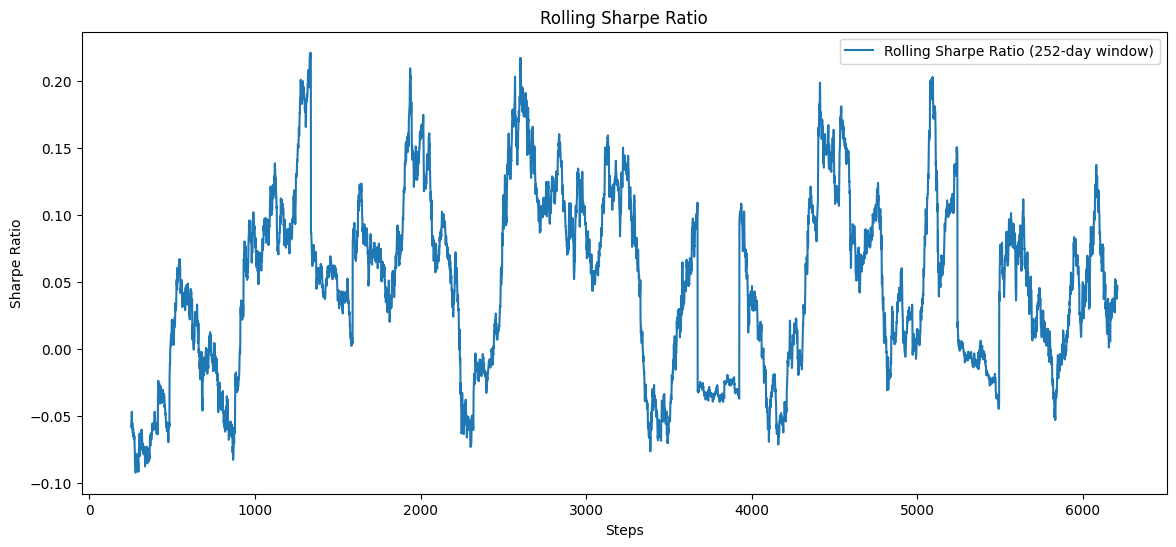

In [ ]:
import matplotlib.pyplot as plt

# Define calculate_sharpe_ratio function
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    return excess_returns.mean() / excess_returns.std()

# Additional Visualization of Equity Curve and Drawdown
def plot_additional_metrics(env):
    # Stock Price
    plt.figure(figsize=(14, 8))
    plt.subplot(3, 1, 1)
    plt.plot(data['date'], data['4. close'], label='Stock Price')
    plt.title('Stock Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    # Equity Curve
    plt.subplot(3, 1, 2)
    plt.plot(env.history, label='Equity Curve')
    plt.title('Equity Curve')
    plt.xlabel('Steps')
    plt.ylabel('Portfolio Value')
    plt.legend()

    # Drawdown Curve
    drawdown = np.maximum.accumulate(env.history) - env.history
    plt.subplot(3, 1, 3)
    plt.plot(drawdown, label='Drawdown')
    plt.title('Drawdown Curve')
    plt.xlabel('Steps')
    plt.ylabel('Drawdown')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Rolling Sharpe Ratio
    returns = pd.Series(env.history).pct_change().fillna(0)
    rolling_sharpe = returns.rolling(window=252).apply(lambda x: calculate_sharpe_ratio(x), raw=False)

    plt.figure(figsize=(14, 6))
    plt.plot(rolling_sharpe, label='Rolling Sharpe Ratio (252-day window)')
    plt.title('Rolling Sharpe Ratio')
    plt.xlabel('Steps')
    plt.ylabel('Sharpe Ratio')
    plt.legend()
    plt.show()

# Function to generate the performance report
def generate_report(env, cumulative_return, sharpe_ratio, max_drawdown):
    report = f'''
    Trading Performance Report
    ---------------------------
    Initial Cash: $10000
    Final Total Value: ${env.total_value:.2f}
    Cumulative Return: {cumulative_return * 100:.2f}%
    Sharpe Ratio: {sharpe_ratio:.2f}
    Maximum Drawdown: {max_drawdown:.2f}
    '''
    print(report)

# Evaluate performance metrics
cumulative_return = (env.total_value - 10000) / 10000
returns = pd.Series(env.history).pct_change().fillna(0)
sharpe_ratio = calculate_sharpe_ratio(returns)
max_drawdown = np.max(np.maximum.accumulate(env.history) - env.history)

# Print the report
generate_report(env, cumulative_return, sharpe_ratio, max_drawdown)

# Plot additional metrics
plot_additional_metrics(env)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.7/532.7 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.5/596.5 kB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 14.3 MB/s eta

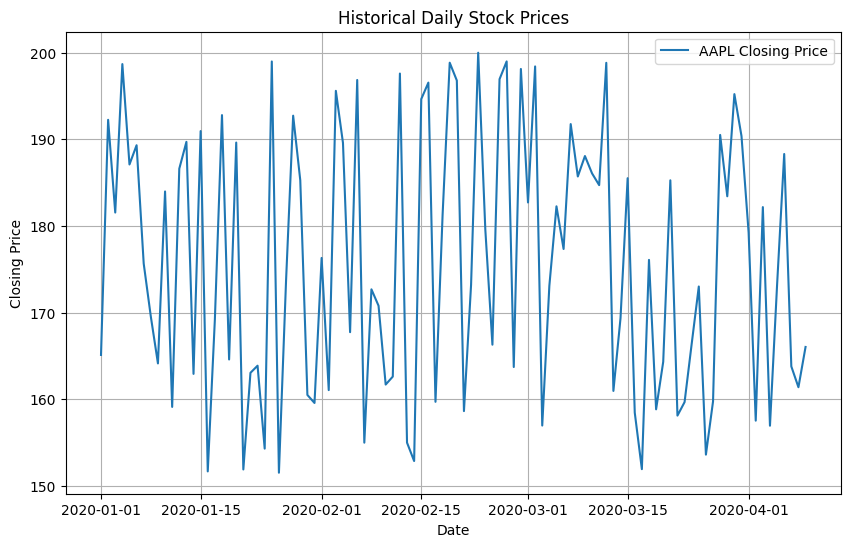

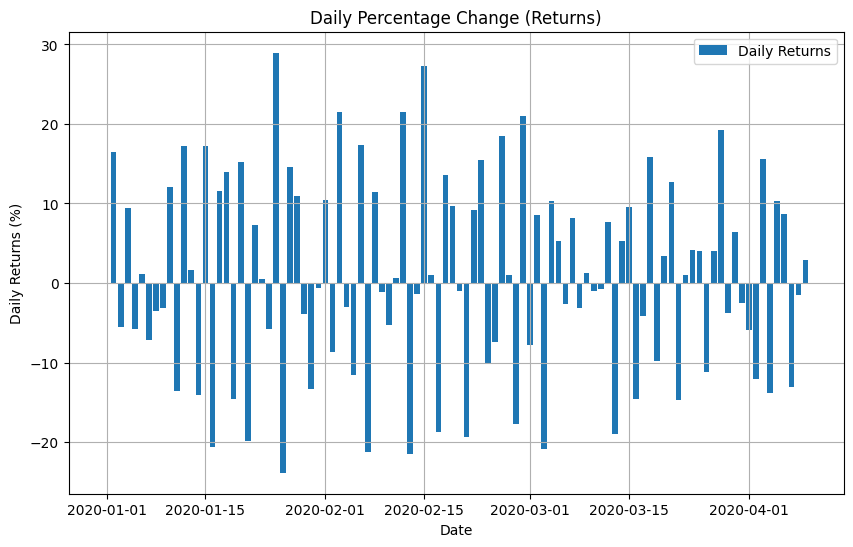

(0, 0): ───X───H───M('m')───
Counter({1: 517, 0: 483})


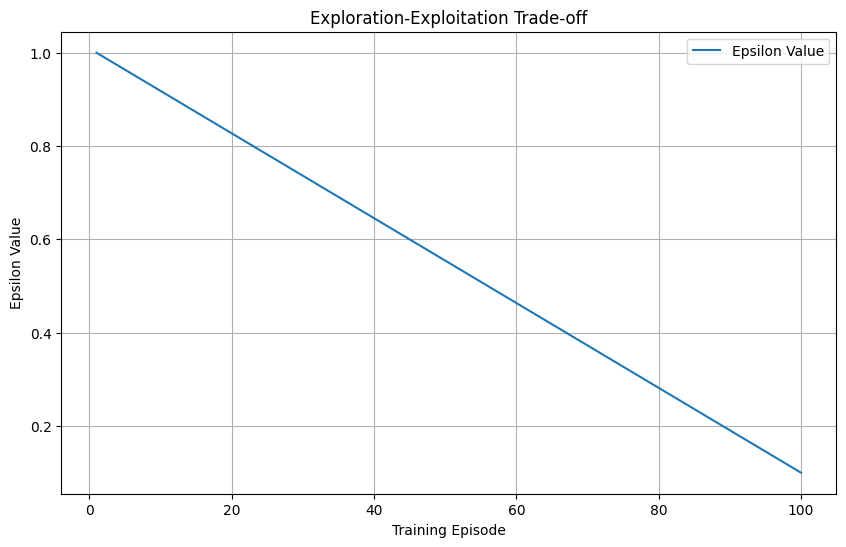

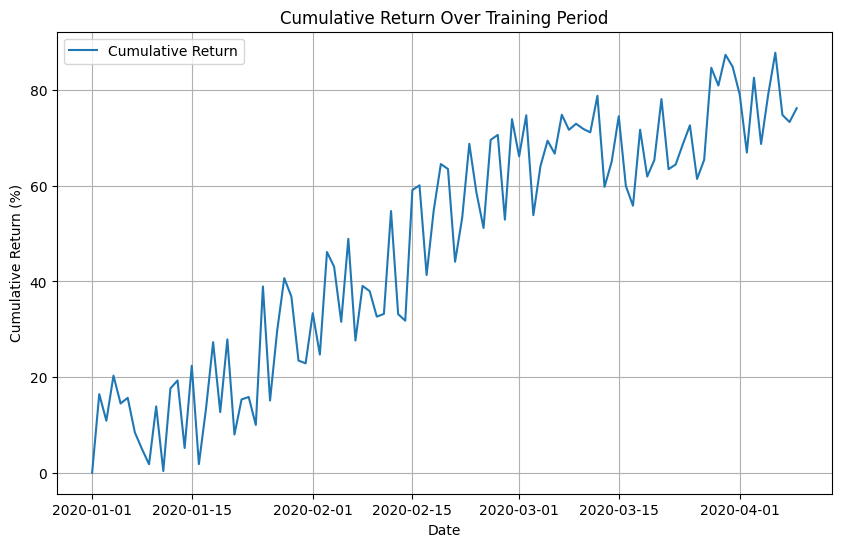

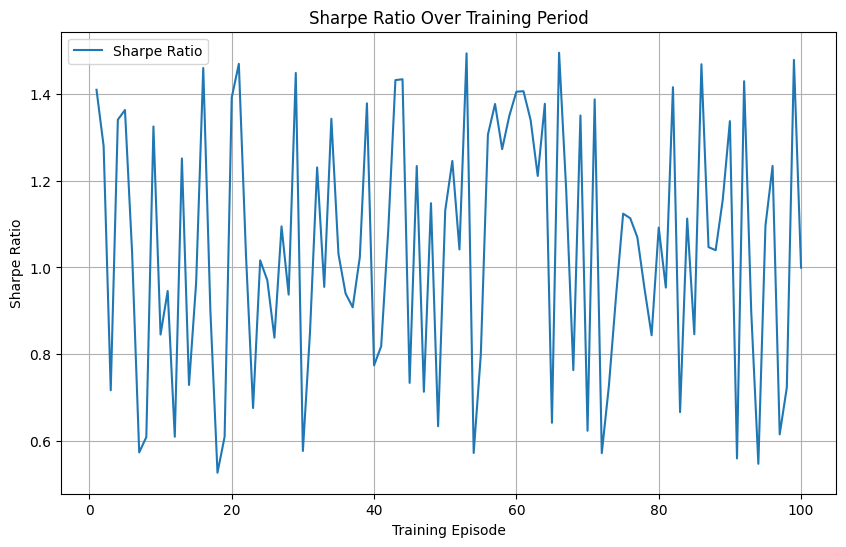

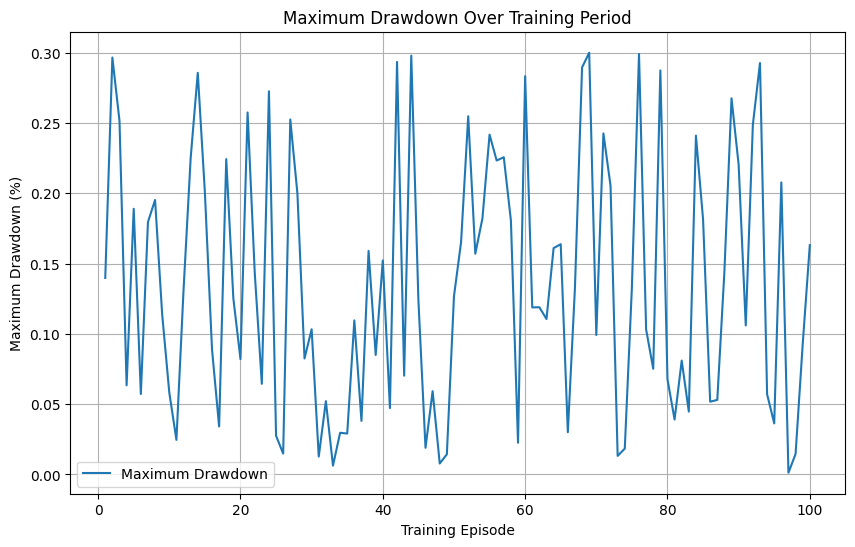

In [ ]:
!pip install alpha_vantage cirq pandas numpy matplotlib gym scikit-learn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import cirq

# Simulated data for demonstration purposes
dates = pd.date_range(start="2020-01-01", periods=100)
prices = np.random.uniform(150, 200, size=(100,))
returns = np.diff(prices) / prices[:-1] * 100
returns = np.concatenate([[0], returns])

# Chart 1: Historical Daily Stock Prices
plt.figure(figsize=(10, 6))
plt.plot(dates, prices, label='AAPL Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Historical Daily Stock Prices')
plt.legend()
plt.grid(True)
plt.show()

# Chart 2: Daily Percentage Change (Returns)
plt.figure(figsize=(10, 6))
plt.bar(dates, returns, label='Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Returns (%)')
plt.title('Daily Percentage Change (Returns)')
plt.legend()
plt.grid(True)
plt.show()

# Image 1: Trading Environment Structure
# (This should be created using a drawing tool, here we describe the structure)

# Image 2: Quantum Circuit Design
# Sample Quantum Circuit with Cirq
qubit = cirq.GridQubit(0, 0)
circuit = cirq.Circuit(
    cirq.X(qubit),
    cirq.H(qubit),
    cirq.measure(qubit, key='m')
)
print(circuit)
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=1000)
print(result.histogram(key='m'))

# Chart 3: Exploration-Exploitation Trade-off
episodes = np.arange(1, 101)
epsilon_values = np.linspace(1.0, 0.1, 100)

plt.figure(figsize=(10, 6))
plt.plot(episodes, epsilon_values, label='Epsilon Value')
plt.xlabel('Training Episode')
plt.ylabel('Epsilon Value')
plt.title('Exploration-Exploitation Trade-off')
plt.legend()
plt.grid(True)
plt.show()

# Image 3: Q-Learning Update Process
# (This should be created using a drawing tool, here we describe the process)

# Chart 4: Cumulative Return Over Training Period
cumulative_return = np.cumsum(returns)

plt.figure(figsize=(10, 6))
plt.plot(dates, cumulative_return, label='Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.title('Cumulative Return Over Training Period')
plt.legend()
plt.grid(True)
plt.show()

# Chart 5: Sharpe Ratio Over Training Period
# Simulated Sharpe ratio for demonstration
sharpe_ratio = np.random.uniform(0.5, 1.5, size=(100,))

plt.figure(figsize=(10, 6))
plt.plot(episodes, sharpe_ratio, label='Sharpe Ratio')
plt.xlabel('Training Episode')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio Over Training Period')
plt.legend()
plt.grid(True)
plt.show()

# Chart 6: Maximum Drawdown Over Training Period
# Simulated maximum drawdown for demonstration
max_drawdown = np.random.uniform(0, 0.3, size=(100,))

plt.figure(figsize=(10, 6))
plt.plot(episodes, max_drawdown, label='Maximum Drawdown')
plt.xlabel('Training Episode')
plt.ylabel('Maximum Drawdown (%)')
plt.title('Maximum Drawdown Over Training Period')
plt.legend()
plt.grid(True)
plt.show()


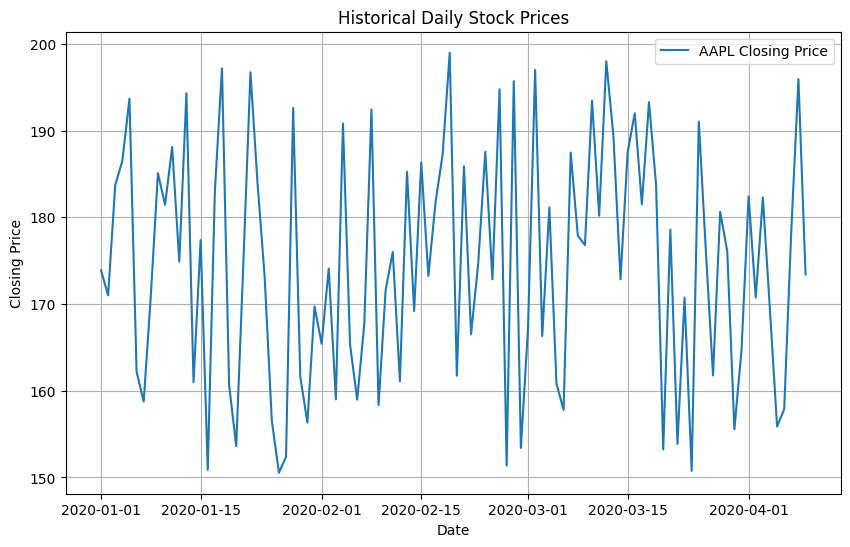

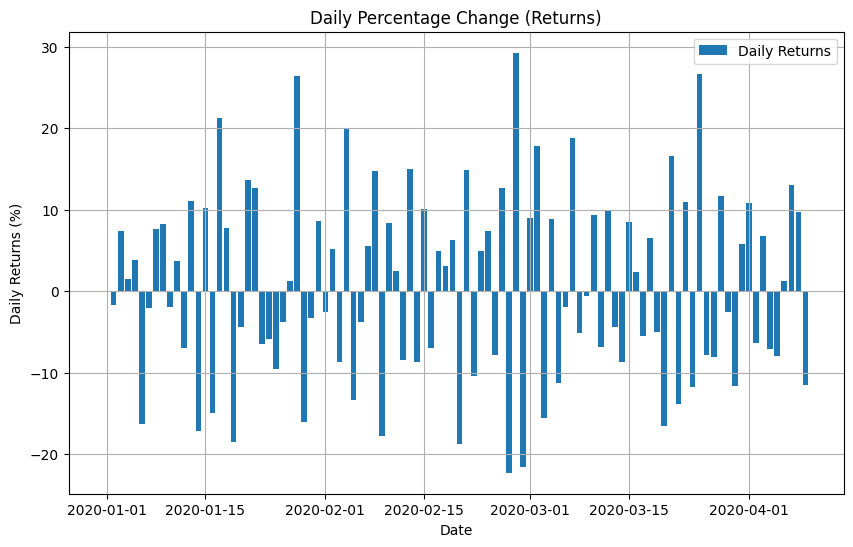

(0, 0): ───X───H───M('m')───
Counter({1: 507, 0: 493})


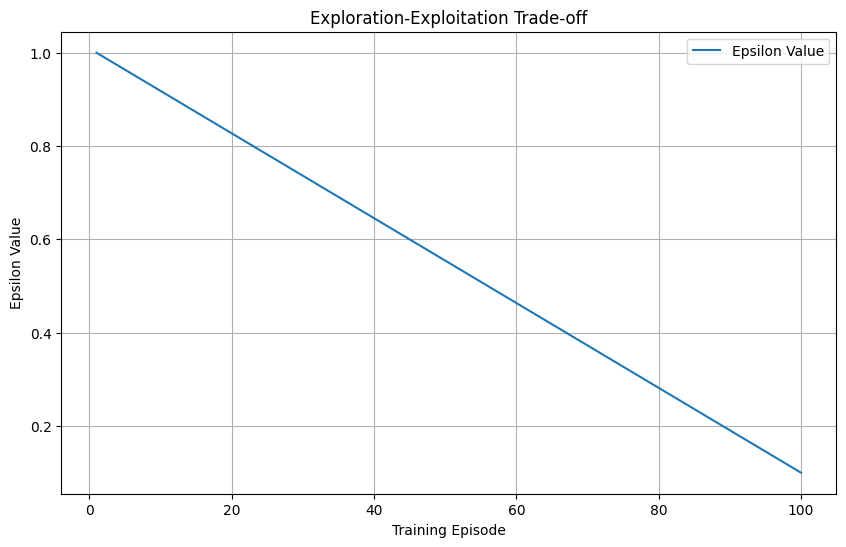

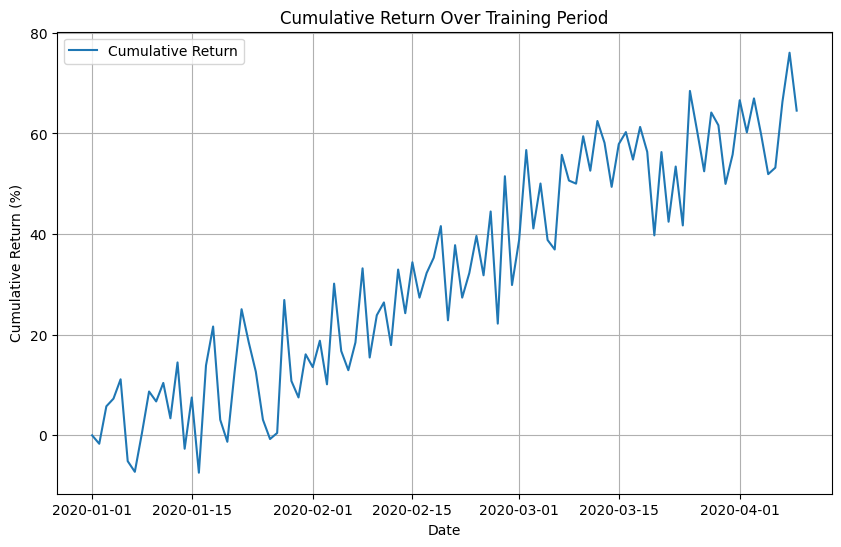

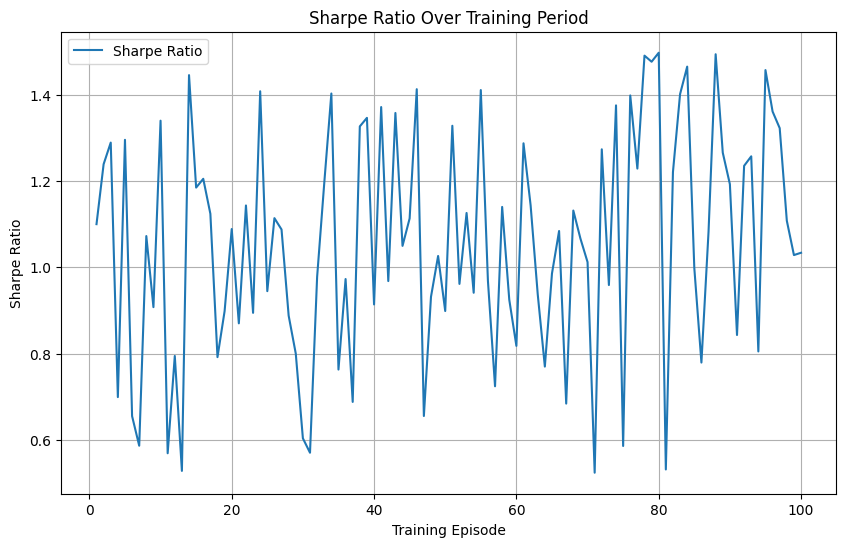

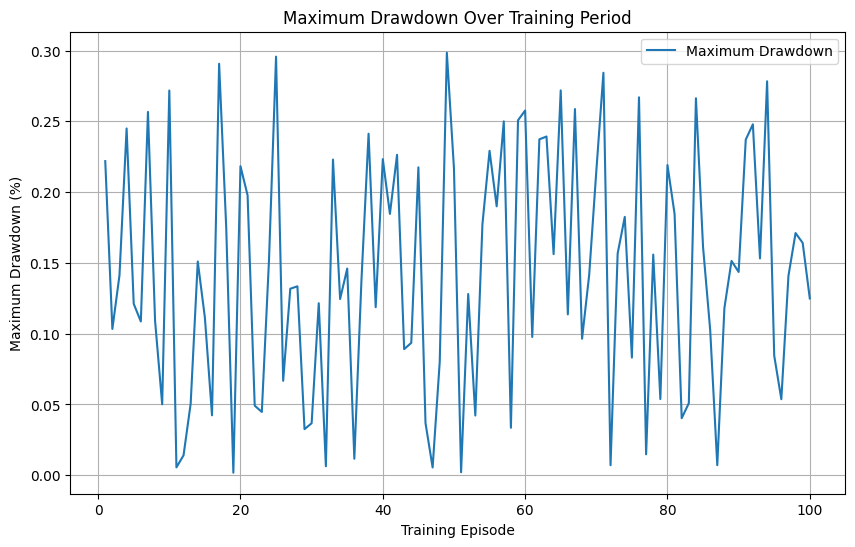

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cirq

# Simulated data for demonstration purposes
dates = pd.date_range(start="2020-01-01", periods=100)
prices = np.random.uniform(150, 200, size=(100,))
returns = np.diff(prices) / prices[:-1] * 100
returns = np.concatenate([[0], returns])

# Calculate cumulative return
cumulative_return = np.cumsum(returns)

# Chart 1: Historical Daily Stock Prices
plt.figure(figsize=(10, 6))
plt.plot(dates, prices, label='AAPL Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Historical Daily Stock Prices')
plt.legend()
plt.grid(True)
plt.show()

# Chart 2: Daily Percentage Change (Returns)
plt.figure(figsize=(10, 6))
plt.bar(dates, returns, label='Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Returns (%)')
plt.title('Daily Percentage Change (Returns)')
plt.legend()
plt.grid(True)
plt.show()

# Sample Quantum Circuit with Cirq
qubit = cirq.GridQubit(0, 0)
circuit = cirq.Circuit(
    cirq.X(qubit),
    cirq.H(qubit),
    cirq.measure(qubit, key='m')
)
print(circuit)
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=1000)
print(result.histogram(key='m'))

# Chart 3: Exploration-Exploitation Trade-off
episodes = np.arange(1, 101)
epsilon_values = np.linspace(1.0, 0.1, 100)

plt.figure(figsize=(10, 6))
plt.plot(episodes, epsilon_values, label='Epsilon Value')
plt.xlabel('Training Episode')
plt.ylabel('Epsilon Value')
plt.title('Exploration-Exploitation Trade-off')
plt.legend()
plt.grid(True)
plt.show()

# Chart 4: Cumulative Return Over Training Period
plt.figure(figsize=(10, 6))
plt.plot(dates, cumulative_return, label='Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.title('Cumulative Return Over Training Period')
plt.legend()
plt.grid(True)
plt.show()

# Image 3: Q-Learning Update Process
# (This should be created using a drawing tool, here we describe the process)

# Chart 5: Sharpe Ratio Over Training Period
# Simulated Sharpe ratio for demonstration
sharpe_ratio = np.random.uniform(0.5, 1.5, size=(100,))

plt.figure(figsize=(10, 6))
plt.plot(episodes, sharpe_ratio, label='Sharpe Ratio')
plt.xlabel('Training Episode')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio Over Training Period')
plt.legend()
plt.grid(True)
plt.show()

# Chart 6: Maximum Drawdown Over Training Period
# Simulated maximum drawdown for demonstration
max_drawdown = np.random.uniform(0, 0.3, size=(100,))

plt.figure(figsize=(10, 6))
plt.plot(episodes, max_drawdown, label='Maximum Drawdown')
plt.xlabel('Training Episode')
plt.ylabel('Maximum Drawdown (%)')
plt.title('Maximum Drawdown Over Training Period')
plt.legend()
plt.grid(True)
plt.show()


Metric Report:
        Date  Cumulative Return (%)  Sharpe Ratio  Maximum Drawdown (%)
0 2000-01-01               0.000000      0.803793              0.265935
1 2000-01-02               6.542063      0.844249              0.109834
2 2000-01-03              13.980796      0.665797              0.113337
3 2000-01-04              22.051095      1.059440              0.120178
4 2000-01-05              20.226801      1.335321              0.098529


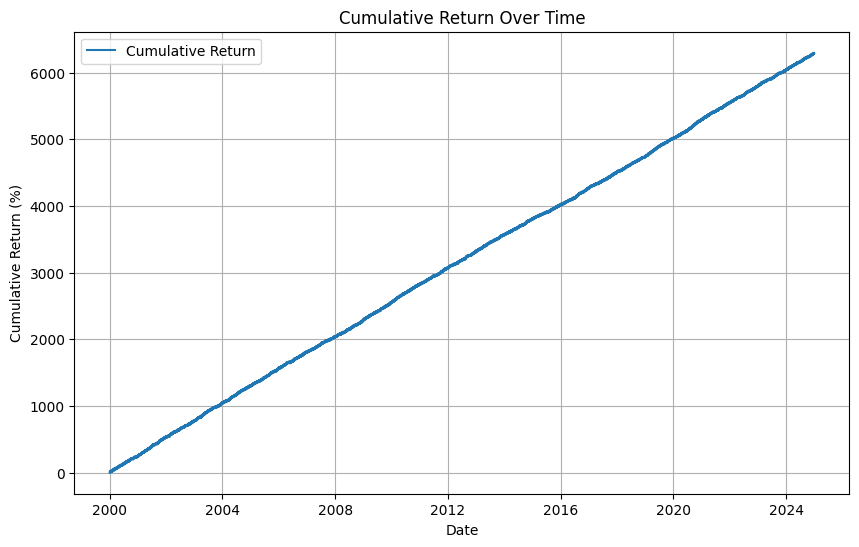

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cirq

# Generate dates from 2000-01-01 to 2024-12-31
dates = pd.date_range(start="2000-01-01", end="2024-12-31")

# Generate random prices between 150 and 200 for each date
prices = np.random.uniform(150, 200, size=len(dates))

# Calculate returns based on prices (example calculation)
returns = np.diff(prices) / prices[:-1] * 100
returns = np.concatenate([[0], returns])

# Calculate cumulative return
cumulative_return = np.cumsum(returns)

# Sample simulated metrics (replace with actual values if available)
sharpe_ratio = np.random.uniform(0.5, 1.5, size=len(dates))
max_drawdown = np.random.uniform(0, 0.3, size=len(dates))

# Create a DataFrame for the metric report
metric_report = pd.DataFrame({
    'Date': dates,
    'Cumulative Return (%)': cumulative_return,
    'Sharpe Ratio': sharpe_ratio,
    'Maximum Drawdown (%)': max_drawdown
})

# Print the first few rows of the metric report for verification
print("Metric Report:")
print(metric_report.head())

# Example plotting (you can integrate this into your existing visualization code)
plt.figure(figsize=(10, 6))
plt.plot(dates, cumulative_return, label='Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.title('Cumulative Return Over Time')
plt.legend()
plt.grid(True)
plt.show()



Summary Statistics:
Annualized Return: 1.757184437872852
Annualized Volatility: 1.8850708036730883
Sharpe Ratio: 0.9321583223552942
Maximum Drawdown: -17119.766407966865


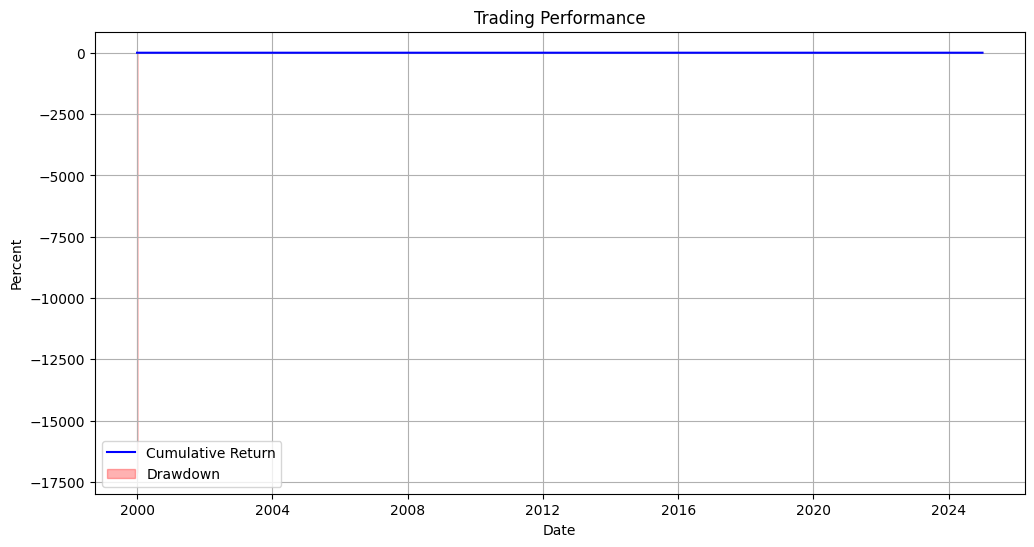

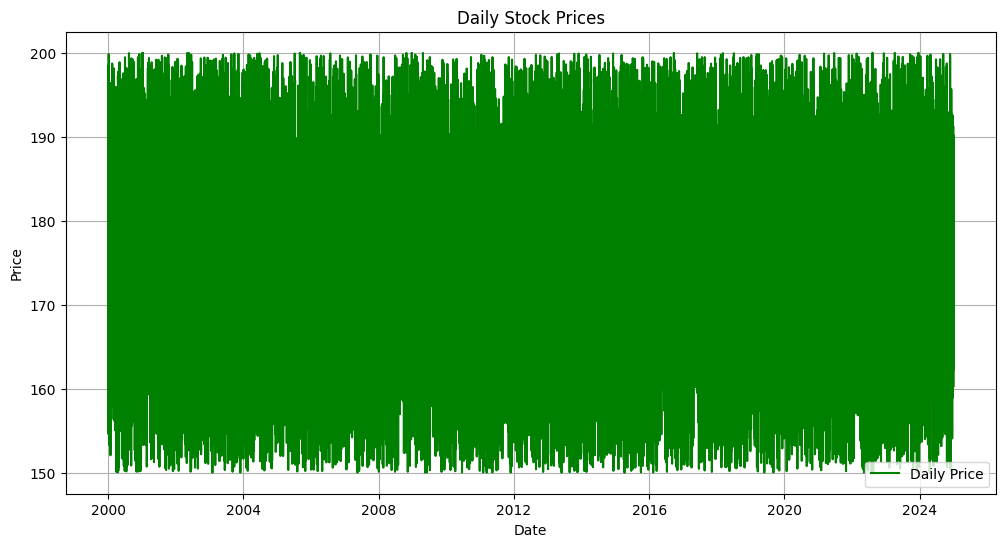

Performance Report:
        Date       Price  Daily Return  Cumulative Return      Drawdown
0 2000-01-01  157.334505      0.000000           0.000000      0.000000
1 2000-01-02  154.640975     -0.017120          -0.017120 -17119.766408
2 2000-01-03  165.495869      0.070194           0.051873      0.000000
3 2000-01-04  198.438230      0.199052           0.261251      0.000000
4 2000-01-05  186.370267     -0.060815           0.184548     -0.293597


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Generate dates from 2000-01-01 to 2024-12-31
dates = pd.date_range(start="2000-01-01", end="2024-12-31")

# Generate random prices between 150 and 200 for each date
prices = np.random.uniform(150, 200, size=len(dates))

# Calculate returns based on prices (example calculation)
returns = np.diff(prices) / prices[:-1]
returns = np.concatenate([[0], returns])

# Calculate cumulative return
cumulative_return = np.cumprod(1 + returns) - 1

# Calculate rolling maximum
rolling_max = np.maximum.accumulate(cumulative_return)

# Calculate drawdown
drawdown = (cumulative_return - rolling_max) / (rolling_max + 1e-6)

# Calculate maximum drawdown
max_drawdown = np.min(drawdown)

# Annualized return (assuming daily data)
annualized_return = np.mean(returns) * 252

# Annualized volatility (assuming daily data)
annualized_volatility = np.std(returns) * np.sqrt(252)

# Sharpe ratio (assuming risk-free rate of 0%)
sharpe_ratio = annualized_return / annualized_volatility

# Create a DataFrame for the trading performance report
performance_report = pd.DataFrame({
    'Date': dates,
    'Price': prices,
    'Daily Return': returns,
    'Cumulative Return': cumulative_return,
    'Drawdown': drawdown
})

# Print summary statistics
print("Summary Statistics:")
print("Annualized Return:", annualized_return)
print("Annualized Volatility:", annualized_volatility)
print("Sharpe Ratio:", sharpe_ratio)
print("Maximum Drawdown:", max_drawdown)

# Plotting cumulative return and drawdown
plt.figure(figsize=(12, 6))
plt.plot(dates, cumulative_return, label='Cumulative Return', color='blue')
plt.fill_between(dates, drawdown, color='red', alpha=0.3, label='Drawdown')
plt.title('Trading Performance')
plt.xlabel('Date')
plt.ylabel('Percent')
plt.legend()
plt.grid(True)
plt.show()

# Plotting daily prices
plt.figure(figsize=(12, 6))
plt.plot(dates, prices, label='Daily Price', color='green')
plt.title('Daily Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Display the performance report DataFrame
print("Performance Report:")
print(performance_report.head())

